In [2]:
import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# Code

In [3]:
#export
from functools import reduce

from typing import Union

from scipy import sparse
import numpy as np

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline

from joblib import effective_n_jobs, Parallel, delayed

from sknetwork.clustering import KMeans, Louvain, PropagationClustering

from heartwood.utils import hstack, RobustEncoder, sparse_dot_product

In [4]:
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

In [5]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [6]:
#export
from sklearn.datasets import make_regression

def sigmoid(x):
    return 1/(1+np.exp(x))

def make_bimodal_assymetric_regression(
    n_samples=100000,
    bimodal_factor_weight = 2,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=10,
    noise=150,
    shuffle=True,
    coef=False,
    random_state=None
):
    
    X,y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_targets=n_targets,
        bias=bias,
        effective_rank=effective_rank,
        tail_strength=tail_strength,
        noise=noise,
        shuffle=shuffle,
        coef=coef,
        random_state=random_state
    )


    #make one of X[1] feature mode weightening    
    bimodal_factors = (sigmoid(bimodal_factor_weight*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
    bimodal_factors[bimodal_factors == 0] = -1
    bimodal_factors = bimodal_factors.reshape(-1,1)

    y = bimodal_factors*y
    
    return X,y

In [65]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
import seaborn as sns

%matplotlib inline

X, y = make_classification(
    n_samples = 10_000,
    n_features = 3,
    n_informative = 3,
    n_redundant = 0,
    #bias = 10,
    #noise = 10,
    n_classes = 4,
    n_clusters_per_class = 2,
    hypercube = True,
)


blobs, labels = make_blobs(n_samples = 10_000,cluster_std = 3, n_features = 4)
#sns.scatterplot(*blobs.T, hue = labels)
#plt.show()

In [82]:
from lightgbm import LGBMClassifier, LGBMRegressor, LGBMModel, LGBMRanker

In [67]:
clf = LGBMClassifier(n_estimators = 10).fit(X,y)

In [68]:
model_df = clf.booster_.trees_to_dataframe()

In [69]:
clf.booster_.trees_to_dataframe()
model_df[model_df["decision_type"].isna()]

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
5,0,6,0-L0,None,None,0-S11,None,NaN,NaN,None,None,None,-1.113742,312.075334,1244
7,0,7,0-L12,None,None,0-S13,None,NaN,NaN,None,None,None,-1.168551,45.406459,181
8,0,7,0-L14,None,None,0-S13,None,NaN,NaN,None,None,None,-1.348408,21.072611,84
10,0,6,0-L6,None,None,0-S7,None,NaN,NaN,None,None,None,-1.445761,25.337306,101
13,0,8,0-L8,None,None,0-S24,None,NaN,NaN,None,None,None,-1.465649,12.794085,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,39,10,39-L26,None,None,39-S29,None,NaN,NaN,None,None,None,0.086620,7.328123,26
2436,39,10,39-L30,None,None,39-S29,None,NaN,NaN,None,None,None,-0.079212,22.348197,135
2437,39,9,39-L29,None,None,39-S28,None,NaN,NaN,None,None,None,0.059206,36.348271,116
2438,39,8,39-L28,None,None,39-S27,None,NaN,NaN,None,None,None,0.079953,43.696702,147


In [70]:
OneHotEncoder().fit_transform(clf.predict(X, pred_leaf = True))

<10000x1240 sparse matrix of type '<class 'numpy.float64'>'
	with 400000 stored elements in Compressed Sparse Row format>

In [83]:
class CustomLGBMClassifier(LGBMClassifier):
    
    def apply(self, X):
        return self.predict(X, pred_leaf = True)
    
    def fit(self, X, y = None, sample_weight = None, **kwargs):
        super().fit(X, y=y, sample_weight=sample_weight, **kwargs)
        model_df = self.booster_.trees_to_dataframe()
        node_weights = model_df[model_df["decision_type"].isna()]["weight"].values
        self.node_weights_ = node_weights
        return self
    
class CustomLGBMRegressor(LGBMRegressor):
    
    def apply(self, X):
        return self.predict(X, pred_leaf = True)
    
    def fit(self, X, y = None, sample_weight = None, **kwargs):
        super().fit(X, y=y, sample_weight=sample_weight, **kwargs)
        model_df = self.booster_.trees_to_dataframe()
        node_weights = model_df[model_df["decision_type"].isna()]["weight"].values
        self.node_weights_ = node_weights
        return self

class CustomLGBMRanker(LGBMRanker):
    
    def apply(self, X):
        return self.predict(X, pred_leaf = True)
    
    def fit(self, X, y = None, sample_weight = None, **kwargs):
        super().fit(X, y=y, sample_weight=sample_weight, **kwargs)
        model_df = self.booster_.trees_to_dataframe()
        node_weights = model_df[model_df["decision_type"].isna()]["weight"].values
        self.node_weights_ = node_weights
        return self


In [78]:
clf = CustomLGBMClassifier(n_estimators = 10).fit(X,y)

/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

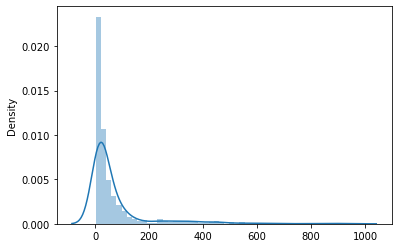

In [80]:
sns.distplot(clf.node_weights_)


In [86]:
nodes = sparse.csr_matrix(OneHotEncoder().fit_transform(clf.apply(X)))
node_weights = clf.node_weights_

In [95]:
(nodes.multiply(node_weights.reshape(1,-1)))

<10000x1240 sparse matrix of type '<class 'numpy.float64'>'
	with 400000 stored elements in COOrdinate format>